In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

In [ ]:
X = mnist['data']
y = mnist['target']

In [ ]:
print(X.shape, y.shape)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
def plot_digits(X):
    some_digit = X
    some_digit = np.array(some_digit)
    some_digit_pic = some_digit.reshape(28, 28)
    fig = plt.figure
    plt.imshow(some_digit_pic, cmap='binary')
    plt.show()

# Binary Classification

In [ ]:
some_digit = X.iloc[[0]].values.tolist()

In [ ]:
plot_digits(some_digit)

In [ ]:
y[0]

In [ ]:
y = y.astype(np.uint8)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [ ]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [ ]:
y_train_5

In [ ]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

In [ ]:
sgd_clf.predict(some_digit)

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [ ]:
sk = StratifiedKFold(n_splits=3, shuffle=True,random_state=42)
n_correct_tot = 0

for train_index, test_index in sk.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    
    X_train_folds, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_folds, y_test_fold = y_train_5[train_index], y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    n_correct_tot += n_correct / len(y_pred)
    print(n_correct / len(y_pred))
print(n_correct_tot/sk.n_splits)

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

In [ ]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

In [ ]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

In [ ]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred)) # == 4096 / (4096 + 1522)

recall_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1325)

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

In [ ]:
y_scores = sgd_clf.decision_function(some_digit)
y_scores

In [ ]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

In [ ]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

In [ ]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [ ]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

In [ ]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [ ]:
print(precision_score(y_train_5, y_train_pred_90), recall_score(y_train_5, y_train_pred_90))


In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    plt.xlabel('False Positive Rate')
    plt.ylabel('Recall')

In [ ]:
plot_roc_curve(fpr, tpr)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [ ]:
y_probas_forest[:,1]

In [ ]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

In [ ]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

roc_auc_score(y_train_5, y_scores_forest)

In [ ]:
y_scores_forest = (y_scores_forest > 0.5)
y_scores_forest

In [ ]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_scores_forest))

recall_score(y_train_5, y_scores_forest)

# End of Binary Classification

# -------------------------------------------------------------------------------------

# Multiclass Classification

In [ ]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train, not y_train_5
svm_clf.predict(some_digit)

In [ ]:
some_digit_scores = svm_clf.decision_function(some_digit)
some_digit_scores

In [ ]:
np.argmax(some_digit_scores)

In [ ]:
svm_clf.classes_

In [ ]:
svm_clf.classes_[5]

In [ ]:
# Takes Much Time
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

In [ ]:
len(ovr_clf.estimators_)

In [ ]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict(some_digit)

In [ ]:
sgd_clf.decision_function(some_digit)

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

In [ ]:
knn_clf.predict(some_digit)

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod.iloc[0]])

In [ ]:
plot_digits([X_test_mod.iloc[0]])

In [ ]:
plot_digits(clean_digit)

In [ ]:
kn_clf = KNeighborsClassifier()

In [ ]:
cross_val_score(kn_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

In [ ]:
def GSCV(X_train, y_train, X_test, y_test):
    estimator_KNN = KNeighborsClassifier()
    parameters_KNN = {
        'n_neighbors': (3, 5, 10),
        'leaf_size': (1, 20, 40),
        'p': (1, 2),
    }
    grid_search_KNN = GridSearchCV(estimator=estimator_KNN, 
                                    param_grid=parameters_KNN,
                                    scoring = 'accuracy',
                                    cv = 3
                                    )
    KNN_1=grid_search_KNN.fit(X_train, y_train)
    y_pred_KNN1 =KNN_1.predict(X_test)
    print(grid_search_KNN.best_params_ ) 
    print('Best Score - KNN:', grid_search_KNN.best_score_ )
    
GSCV(X_train, y_train, X_test, y_test)

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
knn_clf = KNeighborsClassifier()
weight_options = ['uniform', 'distance']
k_range = list(range(4, 11))
param_dist = dict(n_neighbors=k_range, weights=weight_options)
grid_search_KNN = RandomizedSearchCV(estimator=knn_clf, 
                                    param_distributions=param_dist,
                                    scoring = 'accuracy',
                                    cv = 3)
KNN_1=grid_search_KNN.fit(X_train, y_train)
print(grid_search_KNN.best_params_ ) 
print('Best Score - KNN:', grid_search_KNN.best_score_ )

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
para = {'weights': 'distance', 'n_neighbors': 4}
knn_clf = KNeighborsClassifier(**para)
knn_clf.fit(X_train, y_train)

In [ ]:
y_knn_pred = knn_clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

# --------------------------------------------------------------------------------------

In [ ]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])


# Creating Augmented Dataset
X_train_augmented = [image for image in X_train.values]
y_train_augmented = [image for image in y_train]

for dx, dy in ((1,0), (-1,0), (0,1), (0,-1)):
    for image, label in zip(X_train_augmented, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

In [ ]:
len(X_train_augmented) # 60,000 * 5

In [ ]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = np.array(X_train_augmented)[shuffle_idx]
y_train_augmented = np.array(y_train_augmented)[shuffle_idx]

In [ ]:
knn_clf.fit(X_train_augmented, y_train_augmented)
y_knn_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_knn_pred)

# ------------------------------------------------------------

In [ ]:
X = mnist['data']
y = mnist['target']

y = y.astype(np.uint8)

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
SC = StandardScaler()
X_train[X.columns] = SC.fit_transform(X_train[X.columns])
X_test[X.columns] = SC.transform(X_test[X.columns])

In [ ]:
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score

In [ ]:
# Takes to much
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
#svc = SVC()
#param_grid = {'C': [0.1, 1, 10],'gamma': [1, 0.1, 0.01],'kernel': ['rbf']}
#grid_search_svc = GridSearchCV(estimator=svc, param_grid=param_grid,scoring = 'accuracy',cv = 3)
#svc_1 = grid_search_svc.fit(X_train, y_train)
#print(grid_search_svc.best_params_ ) 
#print('Best Score - SVC:', grid_search_svc.best_score_ )

In [ ]:
model = SVC(kernel='rbf', C=10, gamma=1, degree=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
accuracy_score(y_train, y_pred)

In [ ]:
model2 = LinearSVC(random_state=42)
model2.fit(X_train, y_train)
y_pred_2 = model2.predict(X_train)
accuracy_score(y_train, y_pred_2)

In [ ]:
y_pred_2_test = model2.predict(X_test)
accuracy_score(y_test, y_pred_2_test)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal, uniform
#It takes much time
param_distribs =[
    {
        'kernel': ['rbf','poly'],
        "gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10),
        'degree': [2, 3, 4]
    },
    {
        'kernel': ['linear','sigmoid'],
        "gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)
    }
]
model = SVC()

rnd_srch = RandomizedSearchCV(estimator=model, param_distributions=param_distribs, n_iter=10, cv=3, scoring='accuracy',
                                verbose=2, random_state=42)

In [ ]:
rnd_srch.fit(X_train, y_train)

In [ ]:
model = SVC(C=3.8786881587000437, gamma=0.0017076019229344522)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
accuracy_score(y_train, y_pred)

In [ ]:
y_pred_final = model.predict(X_test)
accuracy_score(y_test, y_pred_final)

# -------------------------------------------------------------------

In [ ]:
from sklearn.datasets import fetch_openml
import numpy as np
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

In [ ]:
X = mnist['data']
y = mnist['target']

y = y.astype(np.uint8)

In [ ]:
from sklearn.model_selection import train_test_split
X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size=10000)

In [ ]:
len(X_train1)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=10000)
len(X_train)

In [ ]:
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [ ]:
scores = []
svc_model = LinearSVC(random_state=42)
svc_model.fit(X_train, y_train)
y_svc = svc_model.predict(X_val)
scores.append(accuracy_score(y_val, y_svc))

In [ ]:
rfc_model = RandomForestClassifier(random_state=42)
rfc_model.fit(X_train, y_train)
y_rfc = rfc_model.predict(X_val)
scores.append(accuracy_score(y_val, y_rfc))

In [ ]:
etc_model = ExtraTreesClassifier(random_state=42)
etc_model.fit(X_train, y_train)
y_etc = etc_model.predict(X_val)
scores.append(accuracy_score(y_val, y_etc))

In [ ]:
scores

In [ ]:
sum(scores)/3

In [ ]:
eclf = VotingClassifier(estimators=[('svc', svc_model), ('rfc', rfc_model), ('etc', etc_model)], voting='hard')

In [ ]:
eclf.fit(X_train, y_train)
y_eclf = eclf.predict(X_val)
accuracy_score(y_val, y_eclf)

In [ ]:
eclf2 = VotingClassifier(estimators=[('rfc', rfc_model), ('etc', etc_model)], voting='soft')
eclf2.fit(X_train, y_train)
y_eclf2 = eclf2.predict(X_val)
accuracy_score(y_val, y_eclf2)

In [ ]:
eclf2 = VotingClassifier(estimators=[('rfc', rfc_model), ('etc', etc_model)], voting='hard')
eclf2.fit(X_train, y_train)
y_eclf2 = eclf2.predict(X_val)
accuracy_score(y_val, y_eclf2)

In [ ]:
eclf2.score(X_test, y_test)

In [ ]:
predictions = []
y_svc = svc_model.predict(X_val)
y_rfc = rfc_model.predict(X_val)
y_etc = etc_model.predict(X_val)

In [ ]:
predictions.extend([y_svc, y_rfc, y_etc])

In [ ]:
predictions[0].reshape(-1, 1).shape

In [ ]:
y_val.shape

In [ ]:
blending_scores = []
for fold, pred in enumerate(predictions):
    print(f'fold number: {fold+1}')
    rfc_model.fit(pred.reshape(-1, 1), y_val)
    score = rfc_model.predict(pred.reshape(-1, 1))
    blending_scores.append(accuracy_score(y_val, score))

In [ ]:
sum(blending_scores)/3

In [ ]:
# Without SVM
predictions = []
predictions.extend([y_rfc, y_etc])
blending_scores = []
for fold, pred in enumerate(predictions):
    print(f'fold number: {fold+1}')
    rfc_model.fit(pred.reshape(-1, 1), y_val)
    score = rfc_model.predict(pred.reshape(-1, 1))
    blending_scores.append(accuracy_score(y_val, score))
    
sum(blending_scores)/2

In [ ]:
rfc_model.fit(X_train, y_train)
y_rfc = rfc_model.predict(X_test)

In [ ]:
etc_model.fit(X_train, y_train)
y_etc = etc_model.predict(X_test)

In [ ]:
predictions = []
predictions.extend([y_rfc, y_etc])
blending_scores = []
for fold, pred in enumerate(predictions):
    print(f'fold number: {fold+1}')
    rfc_model.fit(pred.reshape(-1, 1), y_test)
    score = rfc_model.predict(pred.reshape(-1, 1))
    blending_scores.append(accuracy_score(y_test, score))

In [ ]:
sum(blending_scores)/2

### I'm blending and stacking like how I learnt from kaggle.

# --------------------------------------------------

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

In [ ]:
X = mnist['data']
y = mnist['target']
y = y.astype(np.uint8)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000)

In [ ]:
len(X_train)

In [ ]:
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

In [ ]:
start = time.time()
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
print(f'train predictions accuracy is:{accuracy_score(y_train, rfc.predict(X_train))}')
y_pred = rfc.predict(X_test)
end = time.time()
tot_time = end-start
print(f'total time: {tot_time}')
print(accuracy_score(y_test, y_pred))

In [ ]:
pca = PCA(n_components=0.95, random_state=42)

In [ ]:
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

In [ ]:
start = time.time()
rfc.fit(X_train_reduced, y_train)
print(f'train predictions accuracy is:{accuracy_score(y_train, rfc.predict(X_train_reduced))}')
y_pred_reduced = rfc.predict(X_test_reduced)
end = time.time()
tot_time = end-start
print(f'total time: {tot_time}')
print(accuracy_score(y_test, y_pred_reduced))

# 2nd Question in Dimensionality Reduction

In [ ]:
X = mnist['data']
y = mnist['target']
y = y.astype(np.uint8)
indices = np.random.permutation(X.shape[0])[:10000]
len(indices)

X_train = X.iloc[indices]
y_train = y[indices]

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_train)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
X_embedded.shape

In [ ]:
plt.figure(figsize=(13,10))
plt.scatter(x=X_embedded[:,0], y=X_embedded[:,1], c=y_train, cmap='jet')
plt.axis('off')


In [ ]:
import matplotlib as mpl
plt.figure(figsize=(9,9))
cmap = mpl.cm.get_cmap("jet")
for digit in (2, 3, 5):
    plt.scatter(X_embedded[y_train == digit, 0], X_embedded[y_train == digit, 1], c=[cmap(digit / 9)])
plt.axis('off')
plt.show()

In [ ]:
start = time.time()
X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(X_train)
end = time.time()
print(f'total time: {end-start}')

In [ ]:
plt.figure(figsize=(13,10))
plt.scatter(x=X_pca_reduced[:,0], y=X_pca_reduced[:,1], c=y_train, cmap='jet')
plt.axis('off')


In [ ]:
from sklearn.manifold import LocallyLinearEmbedding


In [ ]:
start = time.time()
X_LLe = LocallyLinearEmbedding(n_components=2, random_state=42).fit_transform(X_train)
end = time.time()
print(f'total time: {end-start}')

In [ ]:
plt.figure(figsize=(13,10))
plt.scatter(x=X_LLe[:,0], y=X_LLe[:,1], c=y_train, cmap='jet')
plt.axis('off')

In [ ]:
from sklearn.pipeline import Pipeline

ppl = Pipeline([
    ('PCA', PCA(n_components=0.95, random_state=42)), 
    ('LLE', LocallyLinearEmbedding(n_components=2, random_state=42))
])

In [ ]:
start = time.time()
X_reduced = ppl.fit_transform(X_train)
end = time.time()
print(f'total time: {end-start}')
plt.figure(figsize=(13,10))
plt.scatter(x=X_reduced[:,0], y=X_reduced[:,1], c=y_train, cmap='jet')
plt.axis('off')

# ------------------------------------------

In [1]:
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
X_train.shape

(60000, 28, 28)

In [4]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=10000)
X_train, X_test, X_valid = X_train/255., X_test/255., X_valid/255.

In [58]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(512, activation="relu"),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [59]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
Total params: 567,434
Trainable params: 567,434
Non-trainable params: 0
_________________________________________________________________


In [60]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer='adam',
              metrics=["accuracy"])

In [61]:
filepath="my_mnist_model.h5"
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
cp = tf.keras.callbacks.ModelCheckpoint(filepath, save_best_only=True)

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[es, cp])

Epoch 1/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.2112 - accuracy: 0.9357 - val_loss: 0.1325 - val_accuracy: 0.9593
Epoch 2/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.0912 - accuracy: 0.9721 - val_loss: 0.1026 - val_accuracy: 0.9692
Epoch 3/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.0643 - accuracy: 0.9801 - val_loss: 0.0947 - val_accuracy: 0.9728
Epoch 4/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.0497 - accuracy: 0.9844 - val_loss: 0.0989 - val_accuracy: 0.9714
Epoch 5/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0418 - accuracy: 0.9870 - val_loss: 0.0919 - val_accuracy: 0.9737
Epoch 6/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0348 - accuracy: 0.9891 - val_loss: 0.1072 - val_accuracy: 0.9736
Epoch 7/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0294 - accuracy: 0.9908 - val_loss: 0.0901 - val_accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


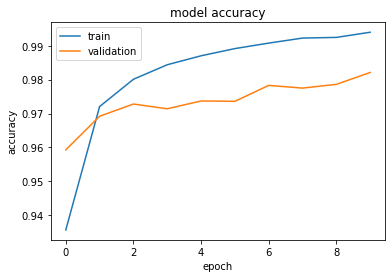

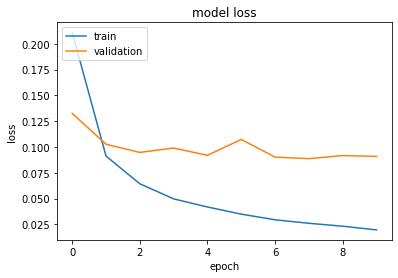

In [62]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [63]:
model.save("my_model")

INFO:tensorflow:Assets written to: my_model\assets


In [64]:
model = keras.models.load_model("my_model")

In [65]:
log_dir

'logs/fit/20211017-015544'

In [35]:
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(X_train, y_train, epochs=15,
                    validation_data=(X_valid, y_valid),
                    callbacks=[es, cp, tensorboard_callback])

Epoch 1/15
   1/1563 [..............................] - ETA: 0s - loss: 1.2293e-07 - accuracy: 0.1562WARNING:tensorflow:From C:\Users\abdel\.conda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1563/1563 [==============================] - 7s 5ms/step - loss: 0.0089 - accuracy: 0.0989 - val_loss: 0.2071 - val_accuracy: 0.0983
Epoch 2/15
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0090 - accuracy: 0.0989 - val_loss: 0.2377 - val_accuracy: 0.0988
Epoch 3/15
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0075 - accuracy: 0.0988 - val_loss: 0.2662 - val_accuracy: 0.0992
Epoch 4/15
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0108 - accuracy: 0.0989 - val_loss: 0.2462 - val_accuracy: 0.0954
Epoch 5/15
1563/1563 [=================

In [66]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0902 - accuracy: 0.0986


[0.09023026376962662, 0.09860000014305115]

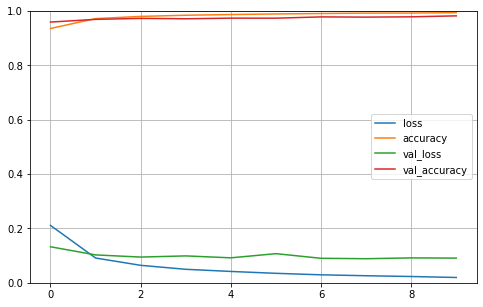

In [72]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [75]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [76]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer='adam',
              metrics=["accuracy"])

In [77]:
history = model.fit(X_train, y_train, epochs=15,
                    validation_data=(X_valid, y_valid),
                    callbacks=[es, cp, tensorboard_callback])

Epoch 1/15
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0260 - accuracy: 0.9929 - val_loss: 0.1029 - val_accuracy: 0.9782
Epoch 2/15
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0153 - accuracy: 0.9957 - val_loss: 0.0948 - val_accuracy: 0.9784
Epoch 3/15
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0175 - accuracy: 0.9948 - val_loss: 0.1146 - val_accuracy: 0.9787
Epoch 4/15
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0149 - accuracy: 0.9956 - val_loss: 0.1394 - val_accuracy: 0.9756
Epoch 5/15
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0170 - accuracy: 0.9952 - val_loss: 0.1232 - val_accuracy: 0.9777
Epoch 6/15
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0155 - accuracy: 0.9953 - val_loss: 0.1159 - val_accuracy: 0.9775


In [74]:
%load_ext tensorboard
%tensorboard --logdir logs/fit
%reload_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 13544), started 12:48:09 ago. (Use '!kill 13544' to kill it.)